In [1]:
function [z, R, H] = getObservation(fp)
    d = fscanf(fp, "%i", "C");
    if (d==1)
      DATA = fscanf(fp, "%f", 5);
      z = DATA(1);
      R = DATA(2);
      H = DATA(3:5)';
    elseif (d==2)
      DATA = fscanf(fp, "%f", 11);
      z = DATA(1:2);
      R = [DATA(3) DATA(4); DATA(4) DATA(5)];
      H = reshape(DATA(6:11), [3,2])';
      % reshape([1;2;3;4;5;6], [3,2])'
    else
      if (!feof(fp))
        disp("Corrupt file.")
      endif
      z = nan;
      R = nan;
      H = nan;
    endif
endfunction

Test file parsing:

In [2]:
raw = fopen("data/A5-MeasurementData.txt", "r");
n_observations = 0;
while (1)
  [z, R, H] = getObservation(raw);
  if (!isnan(z)) % NaN is used to represent EOF
    n_observations += 1;
  else
    break;
  endif
endwhile
fclose(raw);
n_observations

n_observations =  250


In [3]:
function [x_new P_new nv S] = update(x, P, z, R, H)
  S = H * P * H' + R;
  W = P * H' * inv(S);
  nv = z - H * x;
  x_new = x + W * nv;
  P_new = P - W * S * W';
endfunction

## Filtering

In [4]:
x = zeros(3, 1);
P = 100 * eye(3);
Nv = zeros(n_observations, 1);

raw = fopen("data/A5-MeasurementData.txt", "r");
i = 1;
while (1)
  [z, R, H] = getObservation(raw);
  if (!isnan(z))
    [x P nu S] = update(x, P, z, R, H);
    Nv(i) = nu(1) / sqrt(S(1, 1)); % normalized innovations
    i += 1;
  else
    break;
  endif
endwhile
fclose(raw);

## 1. Normalized innovations

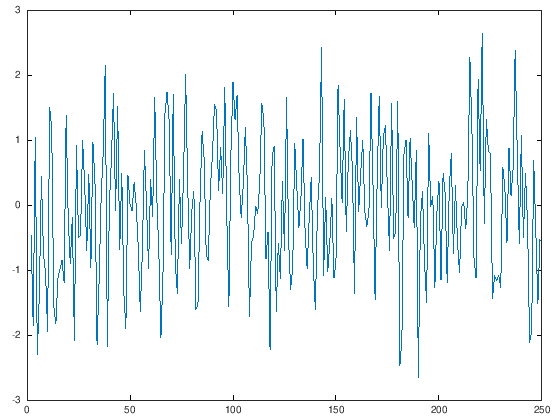

In [5]:
plot(2:n_observations, Nv(2:n_observations))

## 2. Comparison to randn()

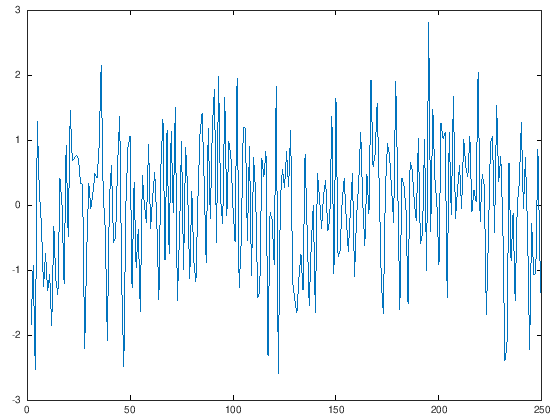

In [6]:
plot(2:n_observations, randn(n_observations-1, 1))

# 3. Innovation signs

In [7]:
% Positive innovations
sum(Nv(2:n_observations)>=0)

ans =  125


In [8]:
% Negative innovations
sum(Nv(2:n_observations)<0)

ans =  124


In [9]:
% Positive innovations given a previous positive innovation
sum((Nv(2:n_observations)>=0).*(Nv(1:n_observations-1)>=0))

ans =  61


In [10]:
% Positive innovations given a previous negative innovation
sum((Nv(2:n_observations)>=0).*(Nv(1:n_observations-1)<=0))

ans =  64


In [11]:
% Negative innovations given a previous positive innovation
sum((Nv(2:n_observations)<0).*(Nv(1:n_observations-1)>=0))

ans =  65


In [12]:
% Negative innovations given a previous negative innovation
sum((Nv(2:n_observations)<0).*(Nv(1:n_observations-1)<0))

ans =  59


In summary, based on the above observations, the signs of innovations have a demonstrated temporal independency, and a uniform distribution. It is safe to conclude that they are not streaky, but random.

## 4. Final estimated mean and covariance

In [13]:
x

x =

     6.0923
    27.9641
   495.9276



In [14]:
P

P =

   0.00779387   0.00021778   0.00025790
   0.00021778   0.00790063   0.00010674
   0.00025790   0.00010674   0.00783463

